# Constrained Optimization

Now consider nonlinear optimization problems $\min_x J(x)$ with inequality constraints of the form $f(x) \leq 0$

First define a simple objective and a NL constraint equation.
Then take the appropriate derivatives


In [8]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.12


In [9]:
#define symbolic vars, function
sx,sy,sxshift=sympy.symbols('x y xshift')
fun = (sx**2 + 2*sx*sy + 8*sy**2)/2
constr = sy - ((sx-sxshift)**3-(sx-sxshift)**2+(sx-sxshift)-1)
test_pt1 = np.array([-3,4])
test_pt2 = np.array([3,-4])

#take the gradient symbolically
gradfun=[sympy.diff(fun,var) for var in (sx,sy)]
gradconstr=[sympy.diff(constr,var) for var in (sx,sy)]

#turn into a bivariate lambda for numpy
numfun=sympy.lambdify([sx,sy],fun)
numgradfun=sympy.lambdify([sx,sy,sxshift],gradfun)
numconstr=sympy.lambdify([sx,sy,sxshift],constr)
numgradconstr=sympy.lambdify([sx,sy,sxshift],gradconstr)

In [10]:
global xshift
xshift = 3 # offset in the constraint function (don't know how to pass a param to a constraint)

def f(X): # simple objective
    x,y = X
    return numfun(x,y)

# NL Constraint
def cons_f(X):
    global xshift
    x,y = X
    return numconstr(x,y,xshift)

def cons_J(X):
    global xshift
    x,y = X
    return numgradconstr(x,y,xshift)

nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 0, jac=cons_J) # inequality UB of zero

x0 = np.array([0.5, 0]) # initial condition

res = minimize(f, x0, method='trust-constr', constraints=[nonlinear_constraint],options={'verbose': 0})
print(f'Constrained solution [{res.x[0]:.2f},{res.x[1]:.2f}]')

Constrained solution [3.21,-0.82]


In [11]:
def plot_result(fig_num = 2, res = 1):
    fig = plt.figure(fig_num, figsize=(8 ,8))
    ax = fig.add_subplot(111)
    CS = ax.contour(X, Y, r, CL)
    ax.clabel(CS, inline=1, fontsize=14)
    ax.set_title('Objective min with nonlinear constraint')
    ax.set_ylim([-Range,Range])
    ax.set_xlim([-Range,Range])
    ax.set_aspect('equal')

    ax.plot(res.x[0], res.x[1], 'bo')
    ax.text(test_pt1[0], test_pt1[1], 'Constraint ftn = '+str(round(cons_f(test_pt1),2)),backgroundcolor='0.75',alpha=.9)
    ax.text(test_pt2[0], test_pt2[1], 'Constraint ftn = '+str(round(cons_f(test_pt2),2)),backgroundcolor='0.75',alpha=.9)
    ax.text(-3, -3, 'Lagrange Mult = '+str(round(res.v[0][0],3)),backgroundcolor='0.75',alpha=1)

    # find the y values of the constraint ftn
    Yb1 = -cons_f(np.array([x,0*x]))
    ax.plot(x,Yb1,'r')

    # plot arrows
    jdel=0.5 # parameter for plotting arrows
    if (res.v[0][0] > 1e-6): # active contraint
        qq,ww = numgradconstr(res.x[0],res.x[1],xshift)
        fqq,fww = numgradfun(res.x[0],res.x[1],xshift)
        ax.arrow(res.x[0],res.x[1], jdel*fqq, jdel*fww, head_width=0.05,head_length=0.1,lw=3,ls='-')
        ax.arrow(res.x[0],res.x[1], jdel*qq, jdel*ww, head_width=0.05,head_length=0.1,lw=3,ls='-',color='g')
    else : # inactive contraint - don't show the arrows
        print('Constraints Inactive')

# Nominal solution

Consider the solution with xshift$=3$. Note that the constraint is written as a $f(x-xshift) \leq 0$.

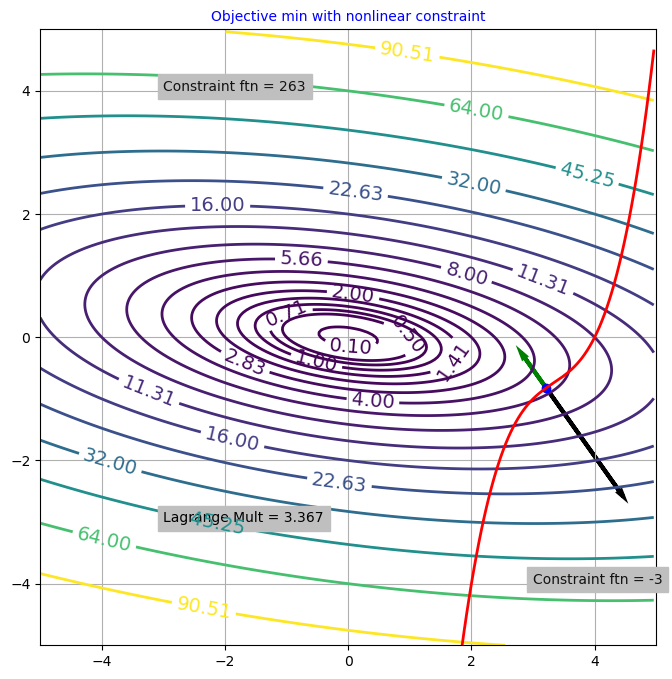

In [12]:
N_samples = 25
Range = 5
x = np.arange(-Range, Range, 1/N_samples)
y = np.arange(-Range, Range, 1/N_samples)
X, Y = np.meshgrid(x, y)

# Objective ftn
r = f(np.array([X,Y])) # contour plot data

# contour colors
CL = 2**np.arange(-1, 7, .5)
CL = np.insert(CL,0,0.1)
# test pts to show the constraint pos/neg regions
test_pt1 = np.array([-3,4])
test_pt2 = np.array([3,-4])
#
plot_result(2,res)
plt.show()

Here:

- Red line is the constraint (positive above left, negative below right). The negative region is the feasible domain for the solution.

- The green arrow points in the direction of the constraint gradient (ie towards the positive/infeasible region)

- The black arrow points in the direction of the function increasing (i.e., away from the min) 

**Note:** at the optimal solution we would expect that 
$$
\frac{\partial J}{\partial \mathbf{x}} = 
- \boldsymbol{\lambda}^T \frac{\partial f}{\partial \mathbf{x}}
$$
So for positive $\lambda$ (i.e., an **active constraint**), would expect these arrows to be pointing in opposite directions. 

If the constraint is **inactive**, then $\lambda =0$ and the conditon is still satisfied, but trivially so.

Here we get:

In [13]:
np.set_printoptions(precision=3,suppress=True)
print(f'At solution [{res.x[0]:.2f},{res.x[1]:.2f}]')
LHS = numgradfun(res.x[0],res.x[1],xshift)
print(f'Function Gradient : [{LHS[0]:.2f},{LHS[1]:.2f}]') 
RHS = -res.v[0]*numgradconstr(res.x[0],res.x[1],xshift)
print(f'-Lambda*(Constraint Gradient) : [{RHS[0]:.2f},{RHS[1]:.2f}]')
print("As noted above, these 2 gradient vectors should be the same")

At solution [3.21,-0.82]
Function Gradient : [2.39,-3.37]
-Lambda*(Constraint Gradient) : [2.39,-3.37]
As noted above, these 2 gradient vectors should be the same


# Experiment: 

Consider what happens to the constrained solution when we change xshift from it nominal value of xshift$=3$. 

In [14]:
def func(xshift_value = 3):
    global xshift # xshift is needed in the solver, so make it accessible here
    xshift = xshift_value
    res = minimize(f, x0, method='trust-constr', constraints=[nonlinear_constraint],options={'verbose': 0})
    print(f'Optimal solution = [{res.x[0]:.3f},{res.x[1]:.3f}]')
    print(f'Lagrange Multiplier = {res.v[0][0]:.3f}')
    print(f'Function at opt sol = {res.fun:.3f}')

    plot_result(3,res)
    txt="Figure 1: Unconstrained min at [0, 0]. \n Constrained solution: "+str(res.x)+"\n Change Xshift to move the constraint ftn"
    plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
    plt.show()
    
y=interactive(func,{'manual': False},xshift_value=(-3.5,4,0.26))
display(y)

interactive(children=(FloatSlider(value=3.0, description='xshift_value', max=4.0, min=-3.5, step=0.26), Output…